In [1]:
import synapseclient
syn = synapseclient.Synapse()

import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE' ##required to keep umap from crashing notebook

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

import numpy as np
import pandas as pd
import seaborn as sns

import umap.umap_ as umap
import matplotlib.pyplot as plt

syn.login()

Welcome, Shuo Gu!



In [2]:
targetspath = syn.get('syn17091507')
readRDS = robjects.r['readRDS']

targets = readRDS(targetspath.path)

In [3]:
targets_filt = (targets
                .query('mean_pchembl > 6')
                .filter(["internal_id", "hugo_gene", "std_name"])
                .drop_duplicates())
    
pd.DataFrame.head(targets_filt)

,internal_id,hugo_gene,std_name
1,3,HTR7,CHEMBL2413451
2,4,CHRNA4,CHEMBL204871
3,4,CHRNB2,CHEMBL204871
4,5,GSK3A,CHEMBL3582401
5,6,FAAH,CHEMBL2386554


In [4]:
targets_filt = (targets
                .query('mean_pchembl > 6')
                .filter(["internal_id", "hugo_gene", "std_name"])
                .drop_duplicates())
    
pd.DataFrame.head(targets_filt)

,internal_id,hugo_gene,std_name
1,3,HTR7,CHEMBL2413451
2,4,CHRNA4,CHEMBL204871
3,4,CHRNB2,CHEMBL204871
4,5,GSK3A,CHEMBL3582401
5,6,FAAH,CHEMBL2386554


In [5]:
drug_data_path = syn.get("syn17462699").path
#export_csv = drug_data.to_csv ("./syn17462699.csv", index = None, header=True)
drug_data = pd.read_csv(drug_data_path, low_memory=False)
                       
pd.DataFrame.head(drug_data)

,model_name,model_type,cellosaurus_id,organism_name,disease_name,disease_efo_id,symptom_name,symptom_efo_id,experiment_synapse_id,study_synapse_id,funder,drug_name,DT_explorer_internal_id,dosage_unit,drug_screen_id,dosage,response_type,response,response_unit
0,ST8814,cell line,CVCL_8916,human,NF1,NaN,MPNST,760.0,syn11958219.1,syn11817821,CTF,(+)-JQ1,103300,uM,1,"[0.00457247370827618,10]",AUC_Simpson,14.146941,NaN
1,ST8814,cell line,CVCL_8916,human,NF1,NaN,MPNST,760.0,syn11958219.1,syn11817821,CTF,BI-847325,136254,uM,10,"[0.00457247370827618,10]",AUC_Simpson,4.021571,NaN
2,ST8814,cell line,CVCL_8916,human,NF1,NaN,MPNST,760.0,syn11958219.1,syn11817821,CTF,Rapamycin (Sirolimus),179479,uM,100,"[0.00457247370827618,10]",AUC_Simpson,20.871279,NaN
3,HCT116 p53-,cell line,CVCL_HD97,human,cancer,311.0,colorectal carcinoma,1001951.0,syn11958252.1,syn11817821,CTF,OSU-03012 (AR-12),258505,uM,1000,"[0.00457247370827618,10]",AUC_Simpson,35.699172,NaN
4,ipNF05.5,cell line,NaN,human,NF1,NaN,pNF,658.0,syn5522645.1,syn4939906,NTAP,NCGC00347953-01,313286,uM,10000,"[0.000780415,46.08295]",AUC_Simpson,50.102748,NaN


In [6]:
pnf = ["ipNF05.5", "ipNF06.2A", "ipNF95.11b C/T", "ipnNF95.11C", "ipNF95.6", "ipNF05.5 (mixed clone)", "ipNF95.11b C"]

drug_data_pnf = (drug_data
      .query('response_type == "IC50_rel"')
      .query('model_name == @pnf')
      .groupby('drug_screen_id').filter(lambda x: len(x)==1)
      .assign(response = lambda x: [50 if a >= 50 else a for a in x['response']]))
 
pd.DataFrame.head(drug_data_pnf)

,model_name,model_type,cellosaurus_id,organism_name,disease_name,disease_efo_id,symptom_name,symptom_efo_id,experiment_synapse_id,study_synapse_id,funder,drug_name,DT_explorer_internal_id,dosage_unit,drug_screen_id,dosage,response_type,response,response_unit
112271,ipNF05.5,cell line,NaN,human,NF1,NaN,pNF,658.0,syn5522645.1,syn4939906,NTAP,NCGC00347953-01,313286,uM,10000,"[0.000780415,46.08295]",IC50_rel,10.035228,uM
112272,ipNF05.5,cell line,NaN,human,NF1,NaN,pNF,658.0,syn5522645.1,syn4939906,NTAP,NCGC00347954-01,313752,uM,10001,"[0.000780415,46.08295]",IC50_rel,31.594513,uM
112273,ipNF05.5,cell line,NaN,human,NF1,NaN,pNF,658.0,syn5522645.1,syn4939906,NTAP,NCGC00347955-01,63637,uM,10002,"[0.000780415,46.08295]",IC50_rel,0.003176,uM
112274,ipNF05.5,cell line,NaN,human,NF1,NaN,pNF,658.0,syn5522645.1,syn4939906,NTAP,NCGC00347956-01,121999,uM,10003,"[0.000780415,46.08295]",IC50_rel,1.265385,uM
112275,ipNF05.5,cell line,NaN,human,NF1,NaN,pNF,658.0,syn5522645.1,syn4939906,NTAP,NCGC00347957-01,268670,uM,10004,"[0.000780415,46.08295]",IC50_rel,3.639111,uM


In [7]:
drug_data_filt = (drug_data_pnf
                  .query('model_name != "ipNF95.11b C"')
                  .groupby('DT_explorer_internal_id').filter(lambda x: len(x)>3)
                  .filter(['DT_explorer_internal_id', 'response','model_name'])
                  .groupby(['DT_explorer_internal_id','model_name'],as_index = False).median())

target_data_filt = (drug_data_pnf
                    .merge(targets, 
                             left_on = "DT_explorer_internal_id",
                             right_on = "internal_id",
                             how = "inner")
                    .filter(["DT_explorer_internal_id", "hugo_gene"])
                   .assign(foo = 1)
                   .pivot_table(values = 'foo', index = 'DT_explorer_internal_id', columns = "hugo_gene", fill_value = 0))

In [8]:
pd.DataFrame.head(target_data_filt)

hugo_gene,A2M,AAK1,ABAT,ABCA1,ABCB1,ABCB11,ABCB4,ABCC1,ABCC5,ABCC8,...,WEE1,WNT3A,WRN,XDH,XIAP,XPO1,YARS,YES1,ZAK,ZAP70
DT_explorer_internal_id,,,,,,,,,,,,,,,,,,,,,
458,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
598,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1702,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1711,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1834,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
pd.DataFrame.head(drug_data_filt)

,DT_explorer_internal_id,model_name,response
0,458,ipNF05.5,0.001354
1,458,ipNF05.5 (mixed clone),0.006432
2,458,ipNF06.2A,0.003290
3,458,ipNF95.11b C/T,0.002239
4,458,ipNF95.6,0.140535


In [10]:
fit = umap.UMAP(
        n_neighbors=3,
        n_components=2,
        metric='euclidean'
    )

u = fit.fit_transform(target_data_filt)

[WARNING] /Users/shuo/anaconda/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)

[WARNING] /Users/shuo/anaconda/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 22 separate connected components using meta-embedding (experimental)
  n_components



In [11]:
df = pd.DataFrame(u)
drugs = target_data_filt.index

df.columns = ['x', 'y']

df['internal_id'] = drugs

std_names = (targets
             .filter(['internal_id', 'std_name'])
             .drop_duplicates())
             
drug_data_pnf_median = (drug_data_pnf
                  .query('model_name != "ipNF95.11b C"')
                  .groupby('DT_explorer_internal_id').filter(lambda x: len(x)>3)
                  .filter(['DT_explorer_internal_id', 'response'])
                  .groupby(['DT_explorer_internal_id'],as_index = False).median())


df = (df
      .merge(std_names, how = 'left')
      .merge(drug_data_pnf_median, left_on = 'internal_id', right_on = "DT_explorer_internal_id", how = "left")
     .sort_values(['response'], ascending = True))

348

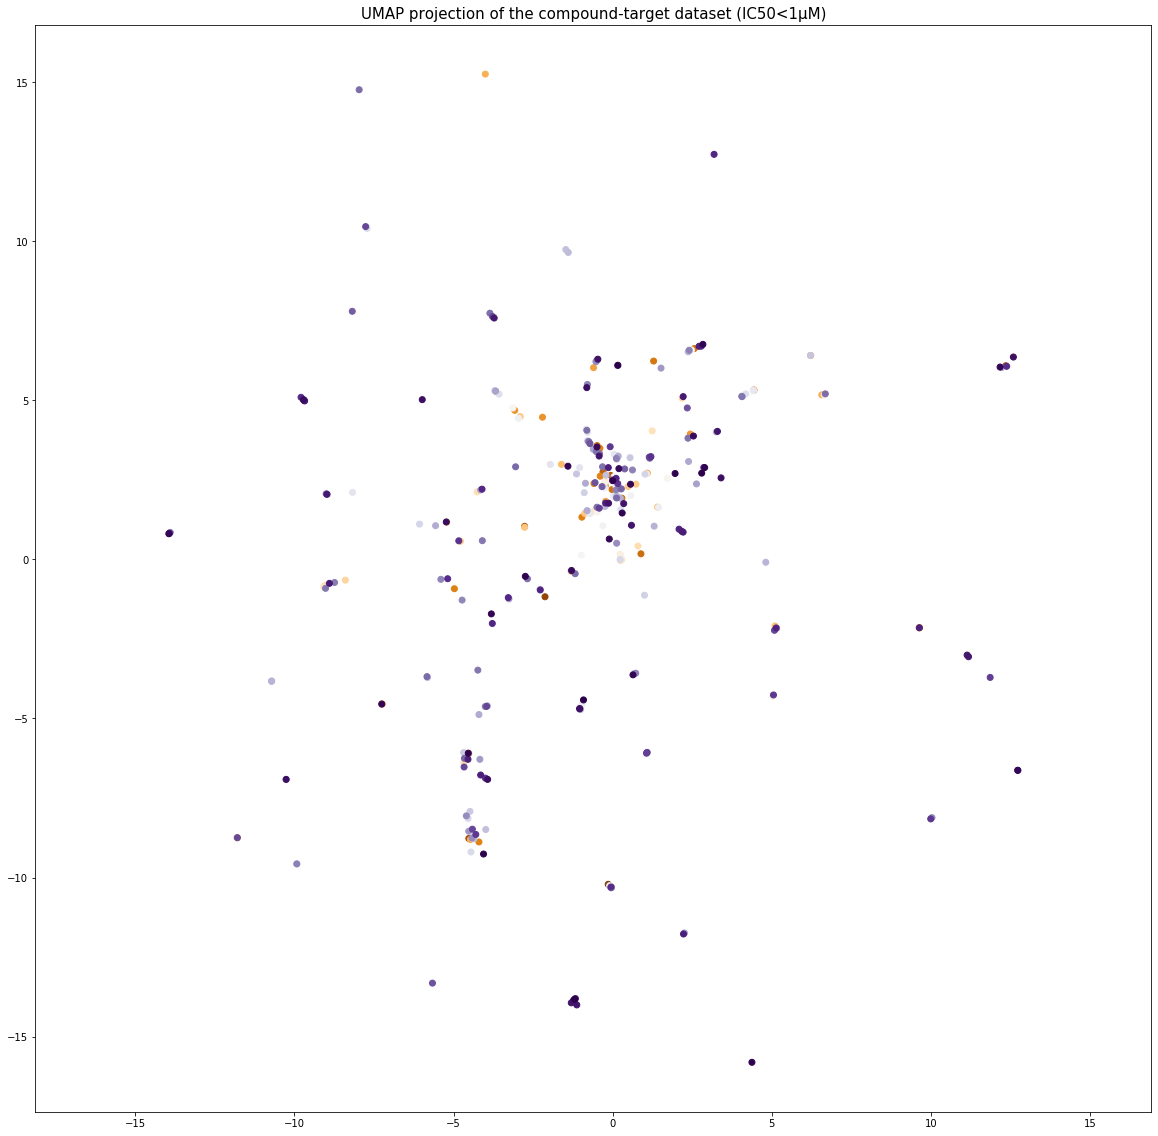

In [12]:
from adjustText import adjust_text


df_short = (df
     .query('response <= 1')
     .reset_index(drop = True))

plt.figure(figsize=(20,20))
plt.scatter(df_short.x, df_short.y, c = np.log(df_short.response), cmap = 'PuOr')
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the compound-target dataset (IC50<1µM)', fontsize=15);

len(df_short)
#texts = [plt.text(df_short.x[i], df_short.y[i], df_short.std_name[i], ha='center', va='center') for i in range(len(df_short.x))]
#adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

In [13]:
df_short.to_csv ("drug348.csv", index = None, header=True)
df_short

,x,y,internal_id,std_name,DT_explorer_internal_id,response
0,-0.072849,-10.281908,15208,CHEMBL1560884,15208.0,0.002647
1,-0.049125,-10.295656,177928,Synephrine,177928.0,0.002716
2,-0.142104,-10.213119,61775,GYKI-52466,61775.0,0.002810
3,4.432652,5.316418,68511,OXYMETAZOLINE,68511.0,0.002934
4,-2.126836,-1.176698,458,Cisplatin,458.0,0.003290
5,-4.521504,-8.771637,61736,Edaravone,61736.0,0.004000
6,-2.769090,1.035573,60066,MILRINONE,60066.0,0.004032
7,12.350941,6.083651,44143,IBUPROFEN,44143.0,0.004073
8,-0.059631,2.635808,223482,METHOCARBAMOL,223482.0,0.004983
9,-7.254719,-4.546081,248772,3-Amino-Benzamide,248772.0,0.005137


In [14]:
target_short_filt = (df_short
                    .merge(targets, 
                             left_on = "DT_explorer_internal_id",
                             right_on = "internal_id",
                             how = "inner")
                    .filter(["DT_explorer_internal_id", "hugo_gene"])
                   .assign(foo = 1)
                   .pivot_table(values = 'foo', index = 'DT_explorer_internal_id', columns = "hugo_gene", fill_value = 0))
pd.DataFrame.head(target_short_filt)

hugo_gene,A2M,AAK1,ABCA1,ABCB11,ABCC8,ABCC9,ABHD5,ABL1,ABL2,ACE,...,VEGFA,VIPR1,VIPR2,WEE1,XDH,XIAP,YARS,YES1,ZAK,ZAP70
DT_explorer_internal_id,,,,,,,,,,,,,,,,,,,,,
458.0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1702.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1711.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1834.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2508.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
targetcount=target_short_filt.sum(axis = 0, skipna = True)
pd.DataFrame.head(targetcount)

hugo_gene
A2M       1
AAK1      3
ABCA1     1
ABCB11    4
ABCC8     2
dtype: int64

In [16]:
genecount=targetcount.to_frame().rename(columns= {0: 'count'}).sort_values(by='count', ascending=False)
genecount.head(30)

,count
hugo_gene,
MAPT,31
TDP1,25
MTOR,18
PIK3CA,18
ADRA2A,16
PIK3CD,15
KCNH2,14
PIK3CB,13
PIK3CG,13


In [17]:
import gseapy
gl=genecount.index.values
gl

array(['MAPT', 'TDP1', 'MTOR', 'PIK3CA', 'ADRA2A', 'PIK3CD', 'KCNH2',
       'PIK3CB', 'PIK3CG', 'ADRA1A', 'ADRA2C', 'ADRA2B', 'HTR2A', 'FLT3',
       'HTR2C', 'ADRA1B', 'CHRM1', 'CA12', 'CA2', 'HTR2B', 'HTR1D',
       'DRD2', 'HTR1A', 'AR', 'NR3C1', 'PIK3C3', 'DRD3', 'CLK1', 'CDK2',
       'PIK3R1', 'GAK', 'PTGS2', 'EGFR', 'PPARG', 'HTR1B', 'NR1I2',
       'TOP2B', 'TOP2A', 'DRD1', 'CA7', 'CA4', 'SLC47A1', 'HRH1', 'CHRM2',
       'ESR1', 'DRD4', 'MET', 'ADRA1D', 'STK10', 'GSK3A', 'GSK3B',
       'PIK3R2', 'PIK3R3', 'PIK3R4', 'CHRM3', 'PIK3R5', 'PIK3R6', 'CA9',
       'CA1', 'CDK1', 'PIK3C2G', 'TUBA4A', 'PTGS1', 'ERBB2', 'PIK3C2A',
       'PIK3C2B', 'FKBP1A', 'HTR6', 'MAOA', 'TUBB', 'RARA', 'SLK', 'SRC',
       'RIPK2', 'HSP90AA1', 'RARB', 'HSP90AB1', 'RXRB', 'TGFBR2', 'ESR2',
       'HCK', 'SYK', 'CCNB1', 'CCNT1', 'DYRK1A', 'HTR7', 'SERPINA3',
       'CHRM4', 'DRD5', 'DCAF7', 'CYP17A1', 'CSNK2A2', 'CSNK2A1', 'CDK4',
       'MAP2K1', 'MAP2K2', 'CDK5', 'CDK5R1', 'CDK6', 'CDK9', 'BRAF',


In [18]:
enrich=gseapy.enrichr(gene_list=list(gl), description='pathway', gene_sets='KEGG_2016', outdir='test')

In [19]:
enrich.results.head(10)

,Adjusted P-value,Combined Score,Gene_set,Genes,Odds Ratio,Old Adjusted P-value,Old P-value,Overlap,P-value,Term
0,3.478788e-88,1926.105962,KEGG_2016,CHRM2;CHRM3;VIPR1;VIPR2;CHRM1;CHRM4;CHRM5;GRPR...,9.302120,0,0,126/277,1.187300e-90,Neuroactive ligand-receptor interaction_Homo s...
1,1.117266e-59,1272.633330,KEGG_2016,CHRM2;VIPR2;CHRM1;PDE3B;PIK3CD;ATP2A2;PIK3CB;H...,9.043171,0,0,88/199,7.626389e-62,cAMP signaling pathway_Homo sapiens_hsa04024
2,1.513302e-52,714.818675,KEGG_2016,FGF1;EDNRA;EDNRB;CCND1;MYC;PRKACG;RASSF5;AKT1;...,5.769241,0,0,112/397,1.549456e-54,Pathways in cancer_Homo sapiens_hsa05200
3,6.810379e-49,2195.243588,KEGG_2016,PSMB11;PSMD12;PSMD11;PSMD14;PSMD13;PSMA7;PSMB1...,19.055587,0,0,41/44,9.297445e-51,Proteasome_Homo sapiens_hsa03050
4,4.622828e-44,837.718305,KEGG_2016,CHRM2;CHRM3;MYLK2;CHRM1;CHRM5;HTR2B;HTR2C;ATP2...,8.066349,0,0,71/180,7.888785e-46,Calcium signaling pathway_Homo sapiens_hsa04020
5,5.237782e-36,577.397168,KEGG_2016,GSK3B;PIK3CD;PIK3CB;PIK3CG;PSMD8;PSMD6;PSMD7;T...,6.782887,0,0,67/202,1.072583e-37,Epstein-Barr virus infection_Homo sapiens_hsa0...
6,2.571584e-35,891.311129,KEGG_2016,SRC;HTR2B;LPAR1;HTR2C;ADRB1;HTR2A;GRM1;EGFR;TU...,10.689719,0,0,46/88,6.143717e-37,Gap junction_Homo sapiens_hsa04540
7,9.593785e-35,726.033552,KEGG_2016,GSK3B;PIK3CD;PIK3CB;PIK3CG;RPS6KA6;RPS6KA5;RPS...,8.861622,0,0,52/120,2.619463e-36,Neurotrophin signaling pathway_Homo sapiens_hs...
8,7.299595e-33,671.384330,KEGG_2016,GSK3B;THRB;THRA;ITGB3;SLC2A1;PIK3CD;ATP2A2;PIK...,8.665211,0,0,50/118,2.242196e-34,Thyroid hormone signaling pathway_Homo sapiens...
9,6.258406e-32,422.298163,KEGG_2016,ZAK;FGF1;TNF;RPS6KA4;RPS6KA6;RPS6KA5;MYC;PRKAC...,5.613697,0,0,70/255,2.135975e-33,MAPK signaling pathway_Homo sapiens_hsa04010


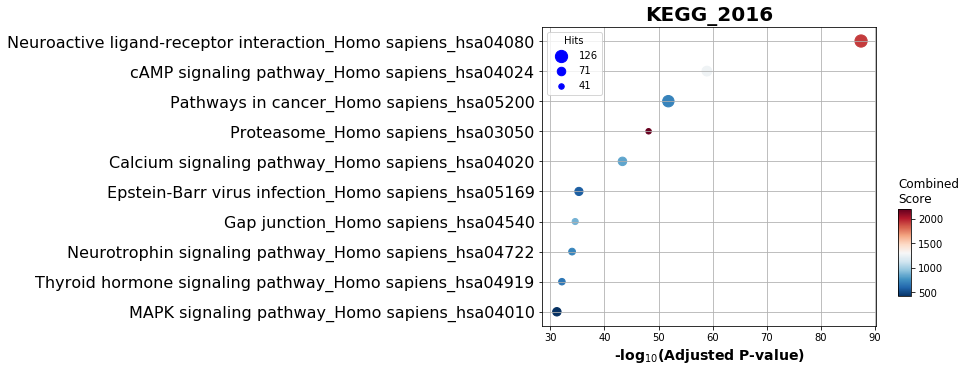

In [20]:
gseapy.dotplot(enrich.res2d, title='KEGG_2016',)

In [21]:
import cirpy
mol=df_short['std_name'].tolist()
moldict={}

for i in mol:
    moldict[i]=cirpy.resolve(i, 'smiles')

In [22]:
from chembl_webresource_client.new_client import new_client
molecule = new_client.molecule

for key in moldict:
    if key[:6]=="CHEMBL":
        moldict[key]=molecule.get(key)['molecule_structures']['canonical_smiles']

In [23]:
import csv
w = csv.writer(open("moldict.csv", "w"))
for key, val in moldict.items():
    w.writerow([key, val])

print(moldict)

{'CHEMBL1560884': 'CN(C)[C@H]1[C@@H]2[C@@H](O)[C@@H]3C(=C)c4cccc(O)c4C(=O)C3=C(O)[C@@]2(O)C(=O)C(=C1O)C(=O)N', 'Synephrine': 'CNCC(O)c1ccc(O)cc1', 'GYKI-52466': 'CC1=NN=C(c2ccc(N)cc2)c3cc4OCOc4cc3C1', 'OXYMETAZOLINE': 'Cc1cc(c(O)c(C)c1CC2=NCCN2)C(C)(C)C', 'Cisplatin': 'N.N.[Cl-].[Cl-].[Pt++]', 'Edaravone': 'CC1=NN(C(=O)C1)c2ccccc2', 'MILRINONE': 'CC1=C(C=C(C#N)C(=O)N1)c2ccncc2', 'IBUPROFEN': 'CC(C)Cc1ccc(cc1)C(C)C(O)=O', 'METHOCARBAMOL': 'COc1ccccc1OCC(O)COC(N)=O', '3-Amino-Benzamide': 'NC(=O)c1cccc(N)c1', 'CHEMBL1434441': 'CCCCCCCCCCCC(CC1OC(=O)C1CCCCCC)OC(=O)C(CC(C)C)NC=O', 'TRIAMCINOLONE ACETONIDE': 'CC1(C)O[C@@H]2C[C@H]3[C@@H]4CCC5=CC(=O)C=C[C@]5(C)[C@@]4(F)[C@@H](O)C[C@]3(C)[C@@]2(O1)C(=O)CO', 'MK-3207': None, 'CHEMBL1651524': 'FC(F)(F)c1ccc(Oc2cccc(CC3CCN(CC3)C(=O)Nc4cccnc4)c2)nc1', 'ALMOTRIPTAN': 'CN(C)CCc1c[nH]c2ccc(C[S](=O)(=O)N3CCCC3)cc12', 'Isoconazole': 'Clc1ccc(C(Cn2ccnc2)OCc3c(Cl)cccc3Cl)c(Cl)c1', 'Pimecrolimus': 'CC[C@@H]1/C=C(/C)C[C@H](C)C[C@H](OC)[C@H]2O[C@](O)([C@H](C